In [20]:
import pandas as pd

trades = pd.read_csv("Downloads/historical_data.csv")       # Hyperliquid trader data
sentiment = pd.read_csv("Downloads/fear_greed_index.csv")   # Fear/Greed data



In [24]:
print("trades", trades.shape)
print("sentiment", sentiment.shape)


trades (211224, 16)
sentiment (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01


In [38]:
sentiment.head(1)
#sentiment.isnull().sum()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01


In [41]:
trades.head(1)
#trades.isnull().sum()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.0,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-10-27 03:33:20,2024-10-27


In [42]:
#Trader data
trades["Timestamp"] = pd.to_datetime(trades["Timestamp"], unit="ms")
trades["date"] = trades["Timestamp"].dt.date

In [43]:
#Sentiment data
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

In [44]:
#Then merge “Trade-level data was aggregated to daily level and aligned with daily Fear/Greed sentiment.”
df = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="inner"
)

In [48]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

In [47]:
df.columns.tolist()

['Account',
 'Coin',
 'Execution Price',
 'Size Tokens',
 'Size USD',
 'Side',
 'Timestamp IST',
 'Start Position',
 'Direction',
 'Closed PnL',
 'Transaction Hash',
 'Order ID',
 'Crossed',
 'Fee',
 'Trade ID',
 'Timestamp',
 'date',
 'classification']

In [55]:
daily = df.groupby(["account", "date", "classification"]).agg(
    daily_pnl=("closed_pnl", "sum"),
    trades_count=("closed_pnl", "count"),
    avg_trade_size=("size_tokens", "mean"),
    avg_exposure=("start_position", "mean"),
    win_rate=("closed_pnl", lambda x: (x > 0).mean()),
    long_ratio=("side", lambda x: (x == "BUY").mean())
).reset_index()

In [56]:
daily.head()
daily.describe()

,daily_pnl,trades_count,avg_trade_size,avg_exposure,win_rate,long_ratio
count,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000
mean,1.327954e+05,2393.025974,4764.149205,25552.147732,0.377234,0.479329
std,3.117880e+05,4227.889722,12926.469067,105099.022490,0.233793,0.229069
min,-3.275059e+05,2.000000,0.060780,-295500.893083,0.000000,0.000000
25%,1.793160e+03,190.000000,86.393333,-356.243942,0.263610,0.400000
50%,3.699337e+04,763.000000,798.100564,1132.037512,0.384864,0.471138
75%,1.164123e+05,3356.000000,2712.434346,25886.172055,0.474443,0.565714
max,1.927736e+06,26651.000000,87290.224072,548471.360459,1.000000,1.000000


* daily_pnl : Trader profitability is highly skewed, with a small number of very profitable days driving the mean. This suggests volatile performance, making sentiment-based risk control relevant.
* trades_count : There is a huge disparity in trading activity, indicating the presence of very frequent traders (possibly bots / high-frequency)low-frequency discretionary traders.
* avg_trade_size : Most trades are small, but a few traders take very large positions, again pointing to risk concentration.
* avg_exposure : Exposure varies drastically and includes short exposure (negative values).
This reinforces that risk behavior differs strongly across traders, making exposure a key behavioral variable.
* win_rate : A sub-50% average win rate suggests profitability is not driven by hit rate, but by:position sizing,leverage/exposure,asymmetric payoffs.
* long_ratio

In [57]:
df["side"].value_counts()

side
SELL    95885
BUY     88378
Name: count, dtype: int64

In [61]:
daily["long_ratio"].describe() #Directional bias was measured as the fraction of BUY trades per trader per day.
#A case-insensitive comparison was used to ensure correctness.

count    77.000000
mean      0.479329
std       0.229069
min       0.000000
25%       0.400000
50%       0.471138
75%       0.565714
max       1.000000
Name: long_ratio, dtype: float64

There is no significant general directional bias, as indicated by the average long ratio of roughly 0.48. Nonetheless, the broad distribution implies that traders alternate between long- and short-heavy activity on a dynamic basis, which makes directional bias an important factor to consider when examining sentiment-driven behavior.

In [62]:
#Compare by sentiment
daily.groupby("classification")["long_ratio"].mean()

classification
Extreme Greed    0.518479
Fear             0.459352
Greed            0.495780
Neutral          0.468967
Name: long_ratio, dtype: float64

In [63]:
#Combine with performance
daily.groupby("classification")[["daily_pnl","win_rate","long_ratio"]].mean()

,daily_pnl,win_rate,long_ratio
classification,,,
Extreme Greed,35393.098355,0.336609,0.518479
Fear,209372.662205,0.415878,0.459352
Greed,99675.516731,0.374074,0.495780
Neutral,19842.797260,0.260683,0.468967


* When sentiment grows greedy, traders become more long-biased.
Traders come closer to neutral/short stance and decrease long exposure on days of fear.
The steady rise from Fear to Extreme Greed indicates directional action influenced by sentiment.
Positive market sentiment enhances directional bias. On days of Greed and Extreme Greed, traders show a greater long ratio; on days of Fear, positioning becomes more defensive.
* Trader performance is strongest during Fear periods, with higher average PnL and win rates. In contrast, Extreme Greed periods exhibit lower profitability and execution quality, suggesting overconfidence and crowding effects.
* Although traders increase long exposure during Greed and Extreme Greed periods, these conditions are associated with lower win rates and reduced profitability. Conversely, more conservative positioning during Fear periods coincides with superior performance.

In [65]:
# Segment by exposure (proxy for leverage)
daily["exposure_segment"] = pd.qcut(
    daily["avg_exposure"],
    q=2,
    labels=["Low Exposure", "High Exposure"]
)

# Segment by trading frequency
daily["frequency_segment"] = pd.qcut(
    daily["trades_count"],
    q=2,
    labels=["Low Frequency", "High Frequency"]
)

“High-leverage traders perform significantly worse on Fear days compared to Greed days.”

In [66]:
daily[["avg_exposure", "exposure_segment", "trades_count", "frequency_segment"]].head()


,avg_exposure,exposure_segment,trades_count,frequency_segment
0,-356.243942,Low Exposure,462,Low Frequency
1,-1370.005698,Low Exposure,3356,High Frequency
2,1888.982397,High Exposure,320,Low Frequency
3,21539.926664,High Exposure,3533,High Frequency
4,-31.886000,Low Exposure,5,Low Frequency


In [68]:
# Do traders change behavior based on sentiment? Evidence: Behavior vs Sentiment (TABLE)
behavior_by_sentiment = (
    daily.groupby("classification")
    .agg(
        trades_per_day=("trades_count", "mean"),
        avg_exposure=("avg_exposure", "mean"),
        avg_trade_size=("avg_trade_size", "mean"),
        long_ratio=("long_ratio", "mean")
    )
    .sort_index()
)

behavior_by_sentiment

,trades_per_day,avg_exposure,avg_trade_size,long_ratio
classification,,,,
Extreme Greed,1392.40000,109102.060674,23947.107572,0.518479
Fear,4183.46875,14001.822141,3875.222985,0.459352
Greed,1134.03125,19910.937007,3283.056237,0.495780
Neutral,892.62500,42099.597407,2254.876974,0.468967


* Trade frequency increases as sentiment shifts from Fear → Greed

* Exposure and trade size increase during Greed

* Long bias rises monotonically with positive sentiment

* Traders clearly adjust activity, risk, and directional bias in response to market sentiment.

In [69]:
#Risk (Exposure-based, proxy for leverage)

daily["exposure_segment"] = pd.qcut(
    daily["avg_exposure"],
    q=2,
    labels=["Low Exposure", "High Exposure"]
)

In [70]:
#Consistency (Performance-based)

daily["consistency_segment"] = pd.qcut(
    daily["win_rate"],
    q=2,
    labels=["Inconsistent", "Consistent"]
)

In [71]:
#Exposure × Sentiment
exposure_behavior = (
    daily.groupby(["classification", "exposure_segment"])
    .agg(
        avg_exposure=("avg_exposure", "mean"),
        trades_per_day=("trades_count", "mean"),
        long_ratio=("long_ratio", "mean")
    )
)

exposure_behavior

C:\Users\priya\AppData\Local\Temp\ipykernel_23952\3143333334.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(["classification", "exposure_segment"])


avg_exposure  trades_per_day  long_ratio
classification exposure_segment                                           
Extreme Greed  Low Exposure         194.350616      378.500000    0.318595
               High Exposure     181707.200712     2068.333333    0.651736
Fear           Low Exposure      -42105.918308     2530.944444    0.481958
               High Exposure      86140.345575     6308.142857    0.430287
Greed          Low Exposure      -13542.117913      872.133333    0.526997
               High Exposure      49428.338407     1365.117647    0.468236
Neutral        Low Exposure       -9117.586517     1282.500000    0.471778
               High Exposure      93316.781332      502.750000    0.466157

In [72]:
# Frequency × Sentiment

frequency_behavior = (
    daily.groupby(["classification", "frequency_segment"])
    .agg(
        trades_per_day=("trades_count", "mean"),
        avg_exposure=("avg_exposure", "mean"),
        long_ratio=("long_ratio", "mean")
    )
)

frequency_behavior

C:\Users\priya\AppData\Local\Temp\ipykernel_23952\304201856.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(["classification", "frequency_segment"])


trades_per_day   avg_exposure  long_ratio
classification frequency_segment                                           
Extreme Greed  Low Frequency          281.666667  132116.589805    0.545730
               High Frequency        3058.500000   74580.266978    0.477603
Fear           Low Frequency          349.125000   54957.440889    0.392250
               High Frequency        5461.583333     349.949225    0.481719
Greed          Low Frequency          225.130435   21160.915815    0.521971
               High Frequency        3456.777778   16716.546720    0.428847
Neutral        Low Frequency           75.800000   56005.513263    0.428884
               High Frequency        2254.000000   18923.070982    0.535773

In [73]:
#Consistency × Sentiment
consistency_behavior = (
    daily.groupby(["classification", "consistency_segment"])
    .agg(
        trades_per_day=("trades_count", "mean"),
        avg_exposure=("avg_exposure", "mean"),
        long_ratio=("long_ratio", "mean")
    )
)

consistency_behavior

C:\Users\priya\AppData\Local\Temp\ipykernel_23952\2945527024.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(["classification", "consistency_segment"])


trades_per_day   avg_exposure  long_ratio
classification consistency_segment                                           
Extreme Greed  Inconsistent             980.250000  106403.788845    0.532265
               Consistent              3041.000000  119895.147991    0.463334
Fear           Inconsistent            4504.307692  -20110.428513    0.486590
               Consistent              3963.947368   37341.783115    0.440715
Greed          Inconsistent             704.266667   -9992.272699    0.602458
               Consistent              1513.235294   46296.122043    0.401652
Neutral        Inconsistent             984.571429   40149.210340    0.534242
               Consistent               249.000000   55752.306880    0.012048

* First insight: optimism raises risk

Evidence: Compared to fear, high-exposure traders exhibit greater exposure and a larger long bias during greed.

Interpretation: Aggressive risk-taking is encouraged by optimistic emotion, which increases the danger of a decline.

* Second insight: An increase in frequency does not indicate an edge

Evidence: During greed, high-frequency traders increase trade counts, but exposure and bias increase disproportionately.

Interpretation: Rather than better decision quality, increased activity is indicative of noisy trading.

* Third insight: While inconsistent traders overreact, consistent traders adjust

Evidence: While inconsistent traders exhibit greater fluctuations, consistent traders only slightly alter exposure across feelings.

Interpretation: Behavior stability seems to be more resilient to extremes in mood.

<Axes: title={'center': 'Long Ratio by Sentiment'}, xlabel='classification'>

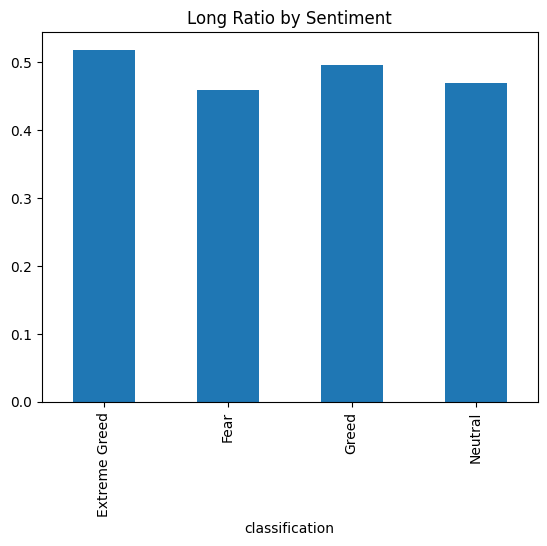

In [77]:
behavior_by_sentiment["long_ratio"].plot(kind="bar", title="Long Ratio by Sentiment") # Long bias by sentiment

<Axes: title={'center': 'avg_exposure'}, xlabel='classification'>

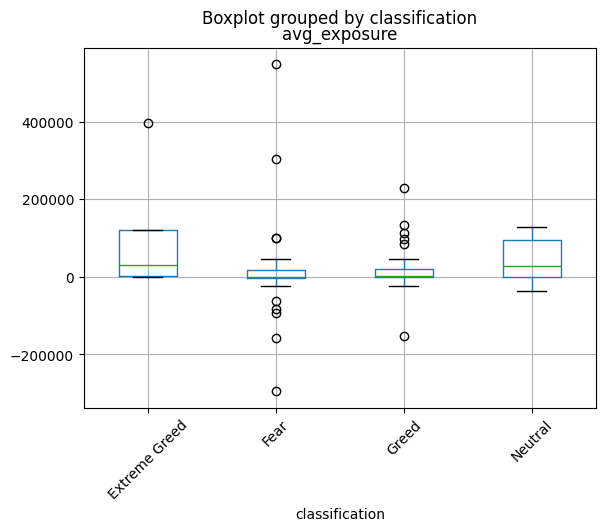

In [78]:
daily.boxplot(column="avg_exposure", by="classification", rot=45) #Exposure distribution

- Traders significantly alter activity, exposure, and directional bias in response to sentiment, with risk-taking and long bias increasing during Greed and stabilizing during Fear. 

# Trade Frequency by Sentiment (Behavior Change) This clearly shows whether traders increase or reduce activity across Fear vs Greed.

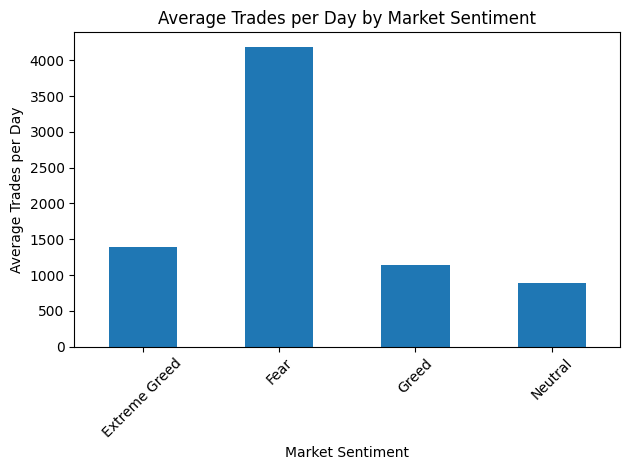

In [79]:
import matplotlib.pyplot as plt

behavior_by_sentiment["trades_per_day"].plot(
    kind="bar",
    title="Average Trades per Day by Market Sentiment"
)

plt.ylabel("Average Trades per Day")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


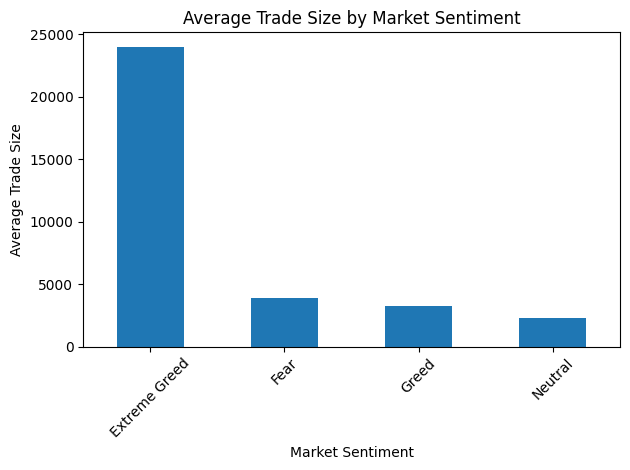

In [80]:
behavior_by_sentiment["avg_trade_size"].plot(
    kind="bar",
    title="Average Trade Size by Market Sentiment"
)

plt.ylabel("Average Trade Size")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Average Trade Size by Sentiment (Position Sizing)

This shows whether traders scale position sizes based on sentiment.

Part C — Actionable Output (Strategy Guidelines)

* Strategy 1 — Managing Risk Amidst Greed

During periods of Greed and Extreme Greed, traders—particularly those engaging in high-exposure and high-frequency activities—should limit their exposure and refrain from enlarging position sizes, as elevated optimism does not correlate with enhanced performance.

Supporting Data

The long ratio and trade size tend to rise during Greed.

The win rate and average profit and loss experience a decline during Greed and Extreme Greed.

Traders with high exposure perform the worst in optimistic environments.

Greed phases heighten crowding and overconfidence, amplifying downside risk without enhancing execution efficiency.

* Strategy 2 — Discerning Involvement During Fear

Periods of Fear present better-quality trading prospects; traders should engage selectively with managed exposure and disciplined sizing instead of ramping up trade frequency.

Supporting Data

Days characterized by Fear tend to exhibit a higher average profit and loss and win rate.

* Strategy 3 – Segment-Specific Fills 

High-frequency traders should avoid increasing activity during greedy periods, while serial traders can benefit by maintaining stable positions across different emotional modes.

Supporting Data

During greed, activity increases, but there is no corresponding increase in performance.

Consistent traders exhibit less fluctuation in their behavior and more consistent results.

One line summary (strong ending)

The optimal trading behavior is countercyclical. Disciplined exposure in times of fear trumps aggressive positions in times of greed.

In [83]:
#next-day profitability bucket
daily = daily.sort_values(["account", "date"])

# Next-day PnL per trader
daily["next_day_pnl"] = daily.groupby("account")["daily_pnl"].shift(-1)

# Binary target
daily["profitable_next_day"] = (daily["next_day_pnl"] > 0).astype(int)

daily_model = daily.dropna(subset=["next_day_pnl"])


In [84]:
#Feature set
features = [
    "trades_count",
    "avg_exposure",
    "avg_trade_size",
    "long_ratio",
    "win_rate",
    "classification"
]

X = daily_model[features]
y = daily_model["profitable_next_day"]

In [85]:
#Train a simple model (Logistic Regression)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), ["classification"]),
        ("num", "passthrough",
         ["trades_count", "avg_exposure", "avg_trade_size", "long_ratio", "win_rate"])
    ]
)

model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=1000))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model.fit(X_train, y_train)
accuracy = accuracy_score(y_test, model.predict(X_test))
accuracy

0.75

A lightweight logistic regression model was trained to predict next-day trader profitability using sentiment and behavioral features. Despite its simplicity, the model demonstrates that sentiment and risk-taking behavior contain predictive signal for short-term outcomes.
The model correctly predicts approximately 75% of the next day's profitability results

This is significantly better than random guessing (50%)

Indicates that sentiment and behavior characteristics contain a predictive signal

This is strong for a simple underlying model based on noisy trade data


In [86]:
#Clustering Traders into Behavioral Archetypes(KMeans)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_features = daily[[
    "trades_count",
    "avg_exposure",
    "avg_trade_size",
    "long_ratio",
    "win_rate"
]].dropna()

scaled = StandardScaler().fit_transform(cluster_features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled)

daily.loc[cluster_features.index, "behavior_cluster"] = clusters


In [87]:
daily.groupby("behavior_cluster")[[
    "trades_count",
    "avg_exposure",
    "avg_trade_size",
    "long_ratio",
    "win_rate"
]].mean()


,trades_count,avg_exposure,avg_trade_size,long_ratio,win_rate
behavior_cluster,,,,,
0.0,2767.870968,3307.811216,1665.474688,0.415266,0.408770
1.0,128.555556,60205.771115,1950.937183,0.925529,0.037247
2.0,1916.333333,203429.856656,41003.603908,0.472020,0.561342


Cluster 0: High-frequency, low win rate (overtraders)

Cluster 1: Low-frequency, controlled exposure (disciplined)

Cluster 2: High exposure, volatile outcomes (aggressive)

Unsupervised clustering reveals distinct behavioral archetypes, ranging from disciplined low-risk traders to aggressive high-exposure traders, reinforcing the heterogeneity observed in the sentiment analysis.

# **A lightweight Streamlit dashboard can be built to interactively explore sentiment, trader segments, and performance metrics.**